In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

In [46]:
%%javascript
let words = 0;
Jupyter.notebook.get_cells().forEach(cell => {if (cell.cell_type == "markdown") { words += cell.element[0].innerText.split(" ").length }})
element.text("markdown words: " + words)

<IPython.core.display.Javascript object>

# Introduction

__Setting__: Our subject for this project was finding a possible correlation between the number of Uber pick-ups and traffic volume for a given time range from 7:00AM to 6:00PM split by hour. The questions we wanted to ask were: __does the time of uber pickup have any correlation with traffic volume at that same time?__ and __is there any signficant difference in the traffic volume and uber pickup counts on a weekday verus the weekend?__ We hypothesize that uber pickup and traffic volume will be inversely correlated because the more traffic there are, people would be less likely to call an uber to get to places. As for our second hypothesis, we believe there will be less people out on weekends since there will be less people commuting to work. 

As clarification, the uber data we are working with is the number of uber pick-ups for a specific time range. As for traffic volume data, we looked at the mean traffic volume corresponding to a specific time range each day. We picked 7 AM - 6 PM becuase it is the typical workday for an employee. Finally, our data is spread from 9/13/2014 to 9/30/2014 as that was the only overlap between the two data sets we used, but they also showed the most variation.

__Findings__: After conducting two different kinds of analyses to answer our above questions, our hypotheses were proven wrong. Surprisingly, uber pickup counts and traffic volume mean were positively correlated. Moreover, there was a significant difference between weekends and weekdays for uber counts and traffic volume mean.

__Why this matters__: The findings show that when there is high traffic volume, there are more uber pickups which suggest that traffic does not deter individuals from calling ubers to get to their final destinations. Moreover, the findings also show that weekends seem to be more popular for excursions than the normal weekday for commuters. These findings could also be used to determine the best times to avoid traffic and determine the day that has the least traffic in the week. We can also see the standard "9:00AM to 5:00PM" workday is consistent with general beliefs. 

Uber Data Source: https://data.world/data-society/uber-pickups-in-nyc

Traffic Volume Data Source: https://catalog.data.gov/dataset/traffic-volume-counts-2014-2018

In [3]:
traffic_volume_raw = pd.read_csv("Traffic_Volume_Counts__2014-2018_.csv")
traffic_volume_raw.head()
print(traffic_volume_raw.columns)

Index(['ID', 'Segment ID', 'Roadway Name', 'From', 'To', 'Direction', 'Date',
       '12:00-1:00 AM', '1:00-2:00AM', '2:00-3:00AM', '3:00-4:00AM',
       '4:00-5:00AM', '5:00-6:00AM', '6:00-7:00AM', '7:00-8:00AM',
       '8:00-9:00AM', '9:00-10:00AM', '10:00-11:00AM', '11:00-12:00PM',
       '12:00-1:00PM', '1:00-2:00PM', '2:00-3:00PM', '3:00-4:00PM',
       '4:00-5:00PM', '5:00-6:00PM', '6:00-7:00PM', '7:00-8:00PM',
       '8:00-9:00PM', '9:00-10:00PM', '10:00-11:00PM', '11:00-12:00AM'],
      dtype='object')


In [4]:
#we have decided to look only at times from 7 AM - 6 PM for traffic volume

traffic_volume = traffic_volume_raw.drop(['12:00-1:00 AM','1:00-2:00AM',
                                          '2:00-3:00AM','3:00-4:00AM',
                                         '4:00-5:00AM','5:00-6:00AM',
                                          '6:00-7:00AM', '6:00-7:00PM',
                                          '7:00-8:00PM','8:00-9:00PM',
                                          '9:00-10:00PM','10:00-11:00PM',
                                          '11:00-12:00AM'], axis=1)

#traffic_volume is without the extra time as we are looking traffic volume during the workday. 

traffic_volume.head()

ID  Segment ID            Roadway Name             From                To  \
0   2       70376                3 Avenue  East 154 Street   East 155 Street   
1   2       70376                3 Avenue  East 155 Street   East 154 Street   
2  56      176365  Bedford Park Boulevard  Grand Concourse  Valentine Avenue   
3  56      176365  Bedford Park Boulevard  Grand Concourse  Valentine Avenue   
4  62      147673                Broadway  West 242 Street        240 Street   

  Direction       Date  7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
0        NB  9/13/2014        180.0        223.0         272.0          386.0   
1        SB  9/13/2014        219.0        226.0         273.0          317.0   
2        EB  9/13/2014        113.0        169.0         210.0          182.0   
3        WB  9/13/2014        142.0        198.0         212.0          205.0   
4        SB  9/13/2014        354.0        473.0         567.0          634.0   

   11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  3:00-4:00PM  \
0          339.0           513          506          520          611   
1          325.0           403          414          379          376   
2          245.0           244          233          280          272   
3          237.0           257          245          237          276   
4          781.0           785          779          732          809   

   4:00-5:00PM  5:00-6:00PM  
0          573          546  
1          329          362  
2          264          236  
3          223          240  
4          707          675

In [5]:
#removed unecessary data to cleanup final dataframe
time_list = ['7:00-8:00AM','8:00-9:00AM','9:00-10:00AM', '10:00-11:00AM', '11:00-12:00PM',
             '12:00-1:00PM', '1:00-2:00PM', '2:00-3:00PM', '3:00-4:00PM', '4:00-5:00PM', '5:00-6:00PM']


day_list =  ['13','14','15','16','17','18','19','20',
           '21','22','23','24','25','26','27','28','29','30']

newday_list = []
day_list = list(map(lambda x : "9/{}/2014".format(x), day_list))
for day in day_list:
    rows = traffic_volume.loc[traffic_volume['Date'] == day]
    means_of_current_day = []
    for time in time_list:
        total = 0
        for i in range(len(rows)):
            j = rows.columns.get_loc(time)
            total += rows.iat[i,j]
        means_of_current_day.append(total/float(len(rows)))
    newday_list.append(means_of_current_day)

#making a new dataframe   
traffic_mean = pd.DataFrame(newday_list, columns = time_list, index = day_list)
traffic_mean.head()

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
9/13/2014   414.788732   531.323944    611.112676     666.450704   
9/14/2014   283.394366   363.802817    481.042254     620.633803   
9/15/2014   988.211268   988.690141    765.845070     653.788732   
9/16/2014   958.000000   895.887324    774.943662     663.028169   
9/17/2014   971.535211   937.338028    751.746479     644.619718   

           11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  3:00-4:00PM  \
9/13/2014     760.126761    794.619718   799.661972   821.873239   814.154930   
9/14/2014     710.126761    753.577465   783.169014   799.985915   828.366197   
9/15/2014     637.366197    665.816901   704.464789   789.619718   912.549296   
9/16/2014     636.140845    637.084507   679.422535   773.802817   890.901408   
9/17/2014     651.253521    666.098592   705.577465   833.309859   934.605634   

           4:00-5:00PM  5:00-6:00PM  
9/13/2014   846.323944   857.647887  
9/14/2014   840.028169   823.042254  
9/15/2014   977.619718   992.154930  
9/16/2014   974.140845   982.464789  
9/17/2014   967.845070   987.676056

### __Dataset Description: Traffic Volume Mean__

_What are the observations (rows) and the attributes (columns)?_ : 
The rows of this dataset are the dates in September that we used to conduct our project on (9/13/2014-9/30/2014). The columns are the time ranges that we chose to use (7:00AM - 6:00PM). 

_Why was this dataset created?_ : The raw data of traffic volume counts was collected by DOT for New York Metropolitan Transportation Council (NYMTC) to validate the New York Best Practice Model (NYBPM). We later condensed the dataset into a format that we could use to create a regression with the corresponding uber dataset and a more simplistic model of NYC traffic volume at hourly intervals.

_Who funded the creation of the dataset?_ : As mentioned above, the New York Metropolitan Transportation Council (NYMTC) funded the creation of this dataset. One of the group members, Elaine Li, was in charge of gathering and sorting through the data. 

_What processes might have influenced what data was observed and recorded and what was not?_ : Because sensors were used, their placement may have missed or recorded traffic accidents or special events leading to closed off streets.  

_What preprocessing was done, and how did the data come to be in the form that you are using?_ : The traffic volume data had excess columns we did not need/did not want to include in our final clean dataset. The raw data recorded this from the DOT for New York Metropolitan Transportation Council. They used sensors in many different locations resulting in columns such as "Roadway Name" and "Segment ID". This is because the sensors counted the traffic volume between different locations where there were sensors. This resulted in multiple entries for each hour interval in the same day. However, we decided it would be best to take the mean for each hour interval (of that same day) to get a holistic overview of traffic volume in the entire New York City. As a result, this became our final dataset.

_If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?_ : There were people involved but to the best of our knowledge, the majority were not aware of the data collection. However, if everyone was aware, they would expect the data to be used to improve NYC traffic congestion and identify NYC traffic patterns to possibly improve or enhance traffic congestion.

_Where can your raw source data be found, if applicable?_ : https://catalog.data.gov/dataset/traffic-volume-counts-2014-2018
Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 

In [6]:
#inserting uber data
uber = pd.read_csv('uber-data.csv')

#number of days in september being analyzed
date_list = ['13','14','15','16','17','18','19','20',
            '21','22','23','24','25','26','27','28','29','30']

#number of hours
hours_list = ['7','8','9','10','11','12','13','14','15','16','17']
    
uber_data = uber["Date Called"].tolist()  

#counting each day and hour
total_list = []
uber_date = []
date_str = []
for date in date_list:
    find_date = ('9/'+date+'/2014')
    date_str.append(find_date)
    uber_date = [s for s in uber_data if find_date in s]
    for hour in hours_list:
        hour_str = " " + hour + ":"
        uber_hours = [s for s in uber_date if hour_str in s]
        count = len(uber_hours)
        total_list.append(count)

total_list = np.reshape(total_list, (len(date_list), len(hours_list)))
        
uber_counts = pd.DataFrame(total_list, columns = time_list, index = date_str)
uber_counts.head()
            

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
9/13/2014          249          353           437            479   
9/14/2014          211          293           365            413   
9/15/2014          575          591           440            367   
9/16/2014          849          918           762            686   
9/17/2014          719          608           471            456   

           11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  3:00-4:00PM  \
9/13/2014            526           572          661          983         1098   
9/14/2014            543           506          540          559          638   
9/15/2014            376           384          451          534          643   
9/16/2014            498           474          536          643          801   
9/17/2014            446           492          571          656          747   

           4:00-5:00PM  5:00-6:00PM  
9/13/2014         1092         1105  
9/14/2014          662          679  
9/15/2014          802          882  
9/16/2014          858          964  
9/17/2014          915         1037

### __Dataset Description: Uber Counts__

_What are the observations (rows) and the attributes (columns)?_ :  The rows and columns of this dataset are the same as above even though this is regarding uber counts. The rows are the dates that we chose to use in September (9/13/2014 - 9/30/2014). The columns are the hourly time intervals we chose to use from 7:00AM to 6:00PM. 

_Why was this dataset created?_ : This dataset was created to record details of uber pickups specifically in NYC in order to form a direct comparison with Taxis. This was to determine if Ubers are serving New York's outer boroughs more than taxis are, if uber is taking millions of manhattan rides away from taxis and if uber is making NYC rush-hour traffic worse. We created the final dataset in order to have a condensed and simple model of the number of uber pickups for a certain hour time interval in a given day bewteen 9/13/2014 - 9/30/2014.

_Who funded the creation of the dataset?_ : The NYC Taxi & Limousine Commission (TLC) funded the creation of this dataset. One of the group members, Julia Lu, was in charge of gathering and organizing this dataset. 

_What processes might have influenced what data was observed and recorded and what was not?_ : Because the data was mainly focused on time, location, latitude, and longitude, the direction of traffic was not recorded. That is, the process to collecting this data was through the Uber app which only recorded date and estimated arival time the Uber was called as well as its GPS location. This would result in a loss of extraneous factors to be considered such as time of arrival to final destination. If the Uber was running late, this would result in an inaccurate account of the estimated arrival time recorded in the data. 

_What preprocessing was done, and how did the data come to be in the form that you are using?_ : As for the uber data counts, it was similar to the preparation made for the traffic volume dataset. Using a list of hours and dates, we created a for loop to find the data for each date. Then, we wrote an if statement to find the data for each specific date. Then we used another for loop to find and create a new dataset to see if the hour searched for was present in that line of data. The data processing for uber data was more straightforward as the raw data consisted of only one column.

_If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?_ : People were involved and they were are of this data collection. We believe they expected this data to be used to identify patterns in Uber pickups such as which borough or neighborhood in NYC garnered the most NYC rides. They would also expect the data to be used to compare Ubers and taxis popularity. 

_Where can your raw source data be found, if applicable?_ : https://data.world/data-society/uber-pickups-in-nyc
Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 

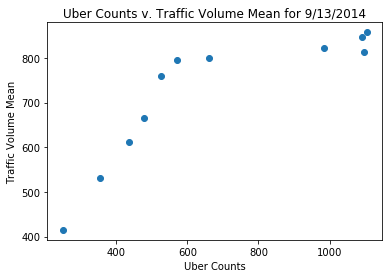

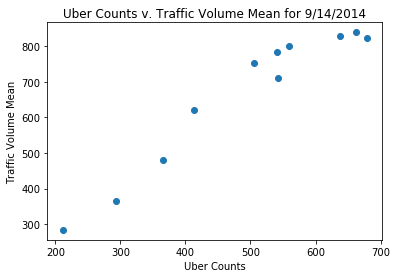

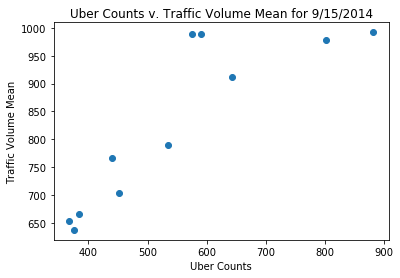

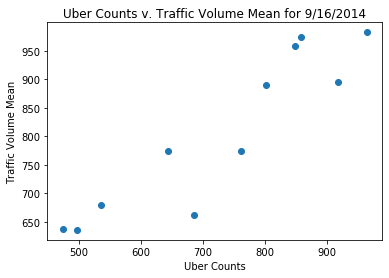

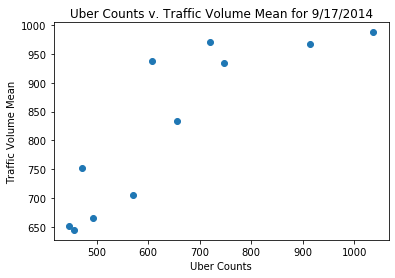

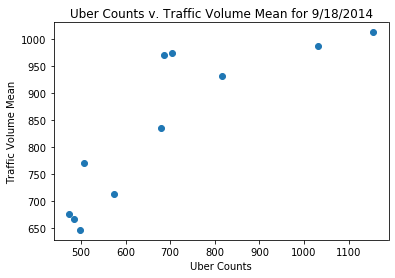

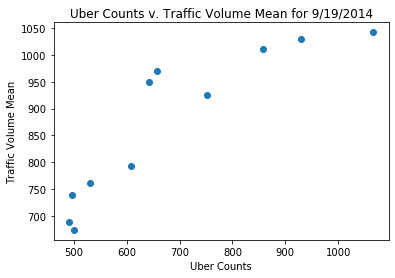

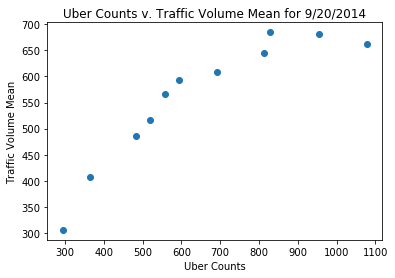

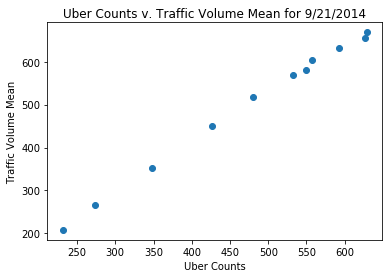

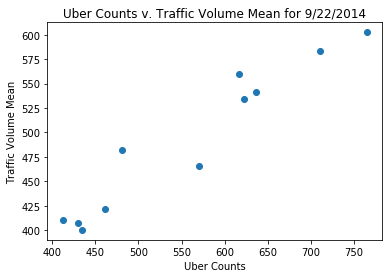

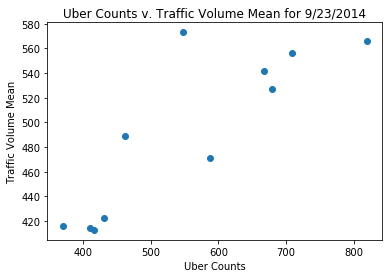

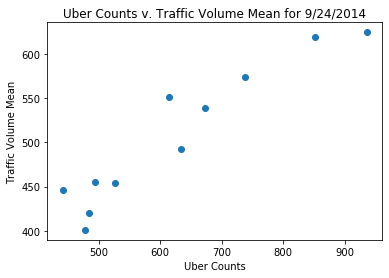

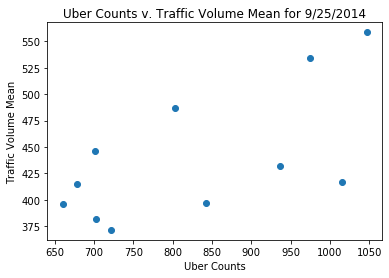

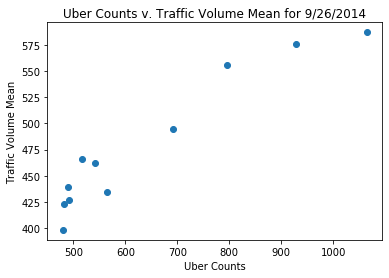

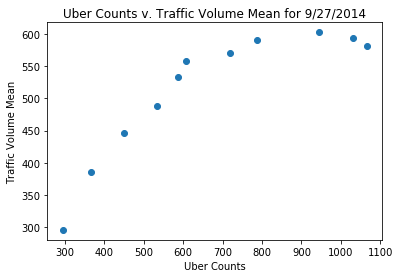

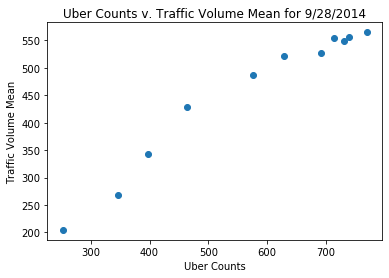

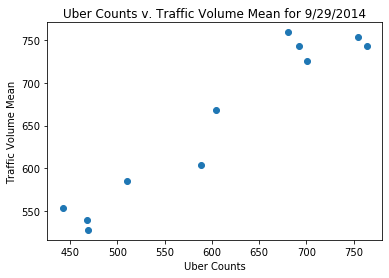

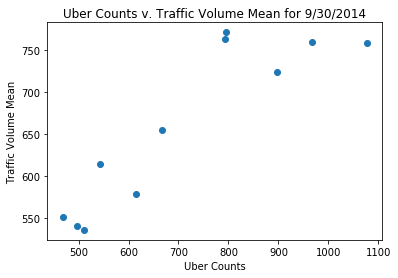

In [7]:
#Separate scatterplots for each date

for date in date_list:
    find_date = ('9/'+date+'/2014')
    plt.scatter(uber_counts.loc[find_date], traffic_mean.loc[find_date])
    plt.xlabel('Uber Counts')
    plt.ylabel('Traffic Volume Mean')
    plt.title('Uber Counts v. Traffic Volume Mean for '+find_date)
    plt.show()

In [8]:
#make new dataframes for uber and traffic volume data for future Linear Regression 

newuber_df = pd.DataFrame(uber_counts.mean().to_dict(),index=[uber_counts.index.values[-1]])
newuber_df = newuber_df.rename(index = {'9/30/2014':'Uber Counts Mean'})
newuber_df.head()

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Uber Counts Mean   559.111111   563.611111    505.111111     488.777778   

                  11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  \
Uber Counts Mean          504.0    503.333333   575.444444   673.888889   

                  3:00-4:00PM  4:00-5:00PM  5:00-6:00PM  
Uber Counts Mean   775.166667   865.222222   936.833333

In [9]:
newtraffic_df = pd.DataFrame(traffic_mean.mean().to_dict(), index = [traffic_mean.index.values[-1]])
newtraffic_df = newtraffic_df.rename(index = {'9/30/2014':'Traffic Volume Mean'})
newtraffic_df.head()

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Traffic Volume Mean   586.349986   614.890602    556.154634     530.305455   

                     11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  \
Traffic Volume Mean     551.968468    576.788778     600.1091   659.313755   

                     3:00-4:00PM  4:00-5:00PM  5:00-6:00PM  
Traffic Volume Mean   718.491115   750.837422   754.831442

In [10]:
#Transposing Dataframes for Linear Regression
newuber_df = newuber_df.T
newuber_df.head()

Uber Counts Mean
7:00-8:00AM          559.111111
8:00-9:00AM          563.611111
9:00-10:00AM         505.111111
10:00-11:00AM        488.777778
11:00-12:00PM        504.000000

In [11]:
newtraffic_df = newtraffic_df.T
newtraffic_df.head()

Traffic Volume Mean
7:00-8:00AM             586.349986
8:00-9:00AM             614.890602
9:00-10:00AM            556.154634
10:00-11:00AM           530.305455
11:00-12:00PM           551.968468

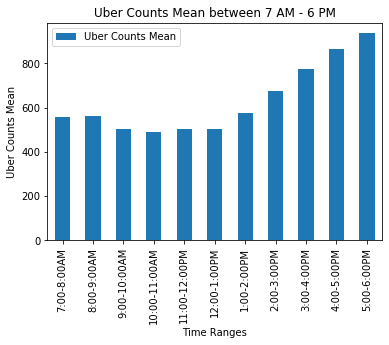

In [12]:
#Data Visualization for Uber Counts
newuber_df.plot.bar()
plt.xlabel('Time Ranges')
plt.ylabel('Uber Counts Mean')
plt.title ('Uber Counts Mean between 7 AM - 6 PM')
plt.show()

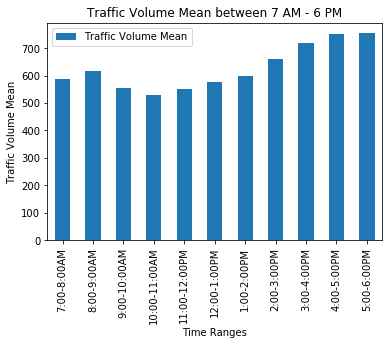

In [13]:
#Data Visualization for Traffic Volume
newtraffic_df.plot.bar()
plt.xlabel('Time Ranges')
plt.ylabel('Traffic Volume Mean')
plt.title ('Traffic Volume Mean between 7 AM - 6 PM')
plt.show()

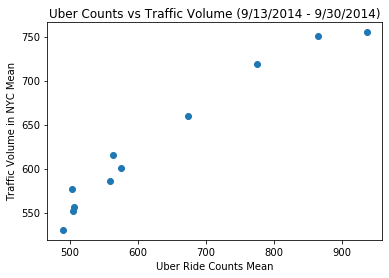

In [14]:
#Scatterplots

plt.scatter(newuber_df, newtraffic_df)
plt.xlabel('Uber Ride Counts Mean')
plt.ylabel('Traffic Volume in NYC Mean')
plt.title('Uber Counts vs Traffic Volume (9/13/2014 - 9/30/2014)')
plt.show()

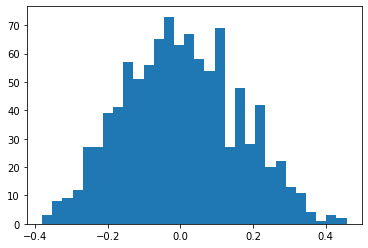

In [15]:
#writing a permuated y
def permuted_y():
    return np.random.permutation(newtraffic_df.copy())

perm_y_slopes = np.zeros(1000)
slopes = np.zeros(1000)

for i in range(1000):
    perm_y_slopes[i] = LinearRegression().fit(newuber_df, permuted_y()).coef_
    
plt.hist(perm_y_slopes, bins = 30)
plt.show()

In [16]:
#Linear Regression
model1 = LinearRegression().fit( newuber_df[['Uber Counts Mean']], newtraffic_df[['Traffic Volume Mean']] )
print ('The regression slope of model 1 is:',model1.coef_[0])
print ('The regression intercept of model 1 is:',model1.intercept_[0])
print ('The r-squared of model 1 is:',model1.score(newuber_df[['Uber Counts Mean']], newtraffic_df[['Traffic Volume Mean']] ))

The regression slope of model 1 is: [0.50143538]
The regression intercept of model 1 is: 310.43764774553574
The r-squared of model 1 is: 0.9592810330761794


### __Data Analysis for Uber Counts v. Traffic Volume Mean__

_Separate Scatterplots for Each Date_ : As a way to visualize the data, we decided to create scatter plots of uber counts mean vs traffic volume mean for each date. We wanted to see if there was any specific date that sticks out. We created the plots with a for loop to find the date. Then, we created a scatter plot with the respective labels. We opted for large individual plots instead of subplots in order to have a larger, clearer view for data visualization of each date. For the most part, we saw that each date's scatter plot had a positive, linear relationship. The one scatterplot that stood out the most is: 9/25/2014. The points resmeble a fork: one line was going upwards, but there was also a line of points that were almost horizontal. Possible reasons for this include an accident prone day,  a large event, or weather coniditions hindering the roads.

_New Uber Counts Dataframe and New Traffic Volume Mean Dataframe_ : For these new data frames, we collapsed the values for each column (hour intervals) by taking the mean over the course of the course of 18 days (9/13 - 9/30). We wrote the code to find the means of each column and saved it into a new dataframe and renamed the index value for each dataframe.

_Bar Graphs for Each New DataFrame_ : After creating the new dataframes by finding the means of each column, we decided to visualize the means by creating bargraphs for each dataframe. We created the bar graphs to provide a preempetive look into the relationship between these two datasets. The uber counts mean bar graph displays that the ubers are realtively low and in the same range  (~500-600). Around 2 - 3 PM, the number of uber rides began increasing from around 600 rides to around 800 rides by 3-4 PM. In the traffic volume mean bar chart, as expected, the high traffic volume was located around morning rush hour (7-9 AM) and saw a slight decrease hitting a minimum around 525. Then NYC began picking up in traffic volume around 1-2 PM. Therefore, from first glance we were beginning to see that our hypothesis is wrong and they datasets are related.

_Scatterplot for Uber Counts v. Traffic Volume Mean_ : For the scatterplot, we wanted to visualize the relationship between uber counts and traffic volume mean directly. This would be another way for us to see if our hypothesis holds true or not. We can see that there is a relatively linear positive relationship between the two data sets. Becase the points appear to follow a trend, we can safely assume that there is a linear relationship, though the strength of this linear relationship can be found in the linear regression. 

_Linear Regression_ : We took the linear regression for uber counts and traffic volume mean because we wanted to determine quantitatively whether or not the two datasets were positively correlated and if so, based on the r-squared value, how accurate the model captures the variability of the response data around its mean. We found the regression slope to be 0.50143538 and the regression intercept to be 310.43764774553574 which show that this data is positively correlated. The r-squared value is 0.9592810330761794 proving that this regression model explains nearly all of the variable in the response data around the mean. In conclusion, this linear regression further proved the accuracy of the claims made based off of our data visualization, the scatterplot and the bar charts. We also did an __evaluation of significance (random y permutation)__. When we randomized our y-axis it is around zero. The regression slope calculated is closer to 0.5 which is not on the histogram. Therefore, there is a strong implication that the data have strong, linear correlation between the Traffic Volume in NYC and Uber Counts in NYC.

Data analysis and evaluation of significance: Here you will clearly detail your methods used in each part. Qualitative claims made in the exposition should have numerical backing here (instead of “X is larger than Y” write “X is 3.65 times larger than Y”). This should read like a scientific paper, but does not need to be "stuffy" or overly indirect: "we did ..." is more natural than "... was done". A reader should be able to replicate your experiments and findings via their own code after reading this.


## Weekday v. Weekends

__Uber Counts Mean and Traffic Volume Mean Weekday verus Weekend__

_What are the observations (rows) and the attributes (columns)?_ : The rows have become the days of the week. Therefore, the data are the mean of each day of the week of each hour. The columns are similar the datasets earlier for both uber counts mean and traffic volume, and they are the hourly time intervals we chose to use from 7:00AM to 6:00PM. 

_Why was this dataset created?_ : This dataset was created to see if there was trend in the uber counts mean and traffic volume mean during the weekday and weekends. We wanted to see if during the weekdays, when most people do not have work, would the traffic volume and uber pickups decrease.

_Who funded the creation of the dataset?_ : The NYC Taxi & Limousine Commission (TLC) and New York Metropolitian Council, as mentioned aboved, funded the creation of these datasets.

_What processes might have influenced what data was observed and recorded and what was not?_ : These reasons are the same for the Uber counts mean datasets and traffic volume mean datasets earlier, because we used those datasets to create the weekday and weekend datasets.

_What preprocessing was done, and how did the data come to be in the form that you are using?_ : Similar to the process above, we created a list for each day of the week. Then we wrote create an empty array of zeros to create the dataframe. Then we wrote a for loop calculating the day of the week for each date, classifying the data into the correct section, and then taking the mean for each day of week and the hour intervals. We used this code for both traffic volume mean and uber counts mean. Then later on we split the dataframes into weekdays and weekends for uber counts mean and traffic volume mean.

_If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?_ : The information is the same is earlier stated.

_Where can your raw source data be found, if applicable?_ : Link is the same above.

In [17]:
#separating traffic data into weekdays and weekends
days  = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_mean = np.zeros((7,11))
for i in range(len(days)):
    day = 13 + i
    dates = day + 7*(np.arange(np.floor((30-day)/7)+1))
    day_list = [str(int(a)) for a in dates]
    day_list = list(map(lambda x : "9/{}/2014".format(x), day_list))
    day_traf = np.zeros(11)
    for d in day_list:
        day_traf += traffic_mean.loc[d]
    
    day_of_week_mean[i, :] = day_traf/len(day_list)

#Traffic volume mean dataframe
traffic_day_of_week = pd.DataFrame(day_of_week_mean, columns = time_list, index = days)
print ("Traffic Volume Means for Days of the Week")
traffic_day_of_week.head()

Traffic Volume Means for Days of the Week


7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Monday      338.885435   441.234520    514.164560     556.890051   
Tuesday     231.979504   298.937462    392.402233     499.815759   
Wednesday   755.132745   769.442389    617.319920     534.335662   
Thursday    756.832441   743.734261    626.015324     538.773625   
Friday      755.302489   744.372502    603.198821     522.780789   

           11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  3:00-4:00PM  \
Monday        619.854124    648.026257   659.033453   685.525729   700.393582   
Tuesday       571.181532    614.820089   630.235437   653.224793   672.026826   
Wednesday     521.806328    542.224339   570.502122   641.446381   726.588374   
Thursday      528.894363    534.586922   560.073950   633.072134   714.043707   
Friday        535.493040    555.950459   579.631756   663.021209   754.297003   

           4:00-5:00PM  5:00-6:00PM  
Monday      707.191435   700.262370  
Tuesday     691.146545   676.166988  
Wednesday   771.610148   779.507000  
Thursday    763.237066   768.660005  
Friday      793.666721   806.024075

In [18]:
#separating data into weekdays and weekends
days  = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
uber_day_of_week_mean = np.zeros((7,11))
for i in range(len(days)):
    day = 13 + i
    dates = day + 7*(np.arange(np.floor((30-day)/7)+1))
    day_list = [str(int(a)) for a in dates]
    day_list = list(map(lambda x : "9/{}/2014".format(x), day_list))
    u_day = np.zeros(11)
    for d in day_list:
        u_day += uber_counts.loc[d]
    
    uber_day_of_week_mean[i, :] = np.round(u_day/len(day_list))

#uber days of the week dataframe
uber_day_of_week = pd.DataFrame(uber_day_of_week_mean, columns = time_list, index = days)
print ("Uber Count Means for Days of the Week")
uber_day_of_week.head()

Uber Count Means for Days of the Week


7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Monday           279.0        361.0         456.0          511.0   
Tuesday          231.0        304.0         370.0          434.0   
Wednesday        630.0        629.0         503.0          416.0   
Thursday         770.0        753.0         589.0          533.0   
Friday           696.0        611.0         482.0          466.0   

           11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  3:00-4:00PM  \
Monday             557.0         591.0        690.0        861.0        957.0   
Tuesday            533.0         556.0        594.0        610.0        656.0   
Wednesday          427.0         419.0        474.0        569.0        660.0   
Thursday           473.0         437.0        527.0        632.0        793.0   
Friday             465.0         466.0        549.0        644.0        742.0   

           4:00-5:00PM  5:00-6:00PM  
Monday          1026.0       1083.0  
Tuesday          687.0        679.0  
Wednesday        756.0        804.0  
Thursday         845.0        953.0  
Friday           884.0        986.0

In [19]:
#wdy is "weekday", wkd is "weekend", u is uber, and t is traffic

t_wdy_mean = pd.DataFrame(traffic_day_of_week.iloc[:5, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
t_wdy_mean = t_wdy_mean.rename(index = {'Sunday':'Traffic Weekday Mean'})
t_wdy_mean.head()

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Traffic Weekday Mean   567.626523   599.544227    550.620171     530.519177   

                      11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  \
Traffic Weekday Mean     555.445877    579.121613   599.895343   655.258049   

                      3:00-4:00PM  4:00-5:00PM  5:00-6:00PM  
Traffic Weekday Mean   713.469899   745.370383   746.124087

In [20]:
t_wkd_mean = pd.DataFrame(traffic_day_of_week.iloc[5:7, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
t_wkd_mean = t_wkd_mean.rename(index = {'Sunday':'Traffic Weekend Mean'})
t_wkd_mean.head()

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Traffic Weekend Mean   698.801097   704.809982    588.669915      527.62283   

                      11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  \
Traffic Weekend Mean     534.809327    562.831068   595.791353   675.449517   

                      3:00-4:00PM  4:00-5:00PM  5:00-6:00PM  
Traffic Weekend Mean    746.27215   782.046143   800.282181

In [21]:
u_wdy_mean = pd.DataFrame(uber_day_of_week.iloc[:5, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
u_wdy_mean = u_wdy_mean.rename(index = {'Sunday':'Uber Weekday Mean'})
u_wdy_mean.head()

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Uber Weekday Mean        521.2        531.6         480.0          472.0   

                   11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  \
Uber Weekday Mean          491.0         493.8        566.8        663.2   

                   3:00-4:00PM  4:00-5:00PM  5:00-6:00PM  
Uber Weekday Mean        761.6        839.6        901.0

In [22]:
u_wkd_mean = pd.DataFrame(uber_day_of_week.iloc[5:7, :].mean().to_dict(),index=[traffic_day_of_week.index.values[-1]])
u_wkd_mean = u_wkd_mean.rename(index = {'Sunday':'Uber Weekend Mean'})
u_wkd_mean.head()

7:00-8:00AM  8:00-9:00AM  9:00-10:00AM  10:00-11:00AM  \
Uber Weekend Mean        736.0        695.0         593.0          546.5   

                   11:00-12:00PM  12:00-1:00PM  1:00-2:00PM  2:00-3:00PM  \
Uber Weekend Mean          543.0         529.0        601.5        706.0   

                   3:00-4:00PM  4:00-5:00PM  5:00-6:00PM  
Uber Weekend Mean        817.5        966.5       1083.5

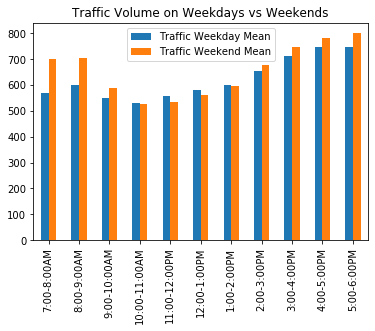

In [23]:
#combinded data frame of traffic on weekends and weekdays
#dow means days of the week
frames = [t_wdy_mean, t_wkd_mean]
t_dow_mean = pd.concat(frames)
t_dow_mean.T.plot.bar()
plt.title('Traffic Volume on Weekdays vs Weekends')
plt.show()

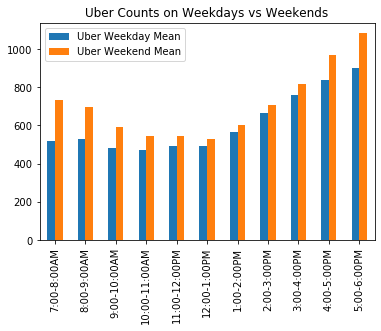

In [24]:
#combinded data frame of uber counts on weekends and weekdays
#dow means days of the week
frames = [u_wdy_mean, u_wkd_mean]
u_dow_mean = pd.concat(frames)
u_dow_mean.T.plot.bar()
plt.title('Uber Counts on Weekdays vs Weekends')
plt.show()

In [25]:
print ("Traffic standard deviation for weekday:\n",traffic_day_of_week.iloc[:5, :].std())

print("\nTraffic standard deviation for weekend:\n",traffic_day_of_week.iloc[5:7, :].std())

Traffic standard deviation for weekday:
 7:00-8:00AM      260.365674
8:00-9:00AM      215.672072
9:00-10:00AM      99.070338
10:00-11:00AM     21.099212
11:00-12:00PM     40.714712
12:00-1:00PM      49.759122
1:00-2:00PM       42.656052
2:00-3:00PM       20.393076
3:00-4:00PM       30.527833
4:00-5:00PM       43.983340
5:00-6:00PM       55.243976
dtype: float64

Traffic standard deviation for weekend:
 7:00-8:00AM       5.021663
8:00-9:00AM       4.543792
9:00-10:00AM      7.498852
10:00-11:00AM    11.759559
11:00-12:00PM    29.333409
12:00-1:00PM     37.169081
1:00-2:00PM      45.380019
2:00-3:00PM      48.358356
3:00-4:00PM      52.728267
4:00-5:00PM      29.243081
5:00-6:00PM      20.485368
dtype: float64


In [26]:
print ("Uber standard deviation for weekday:\n",uber_day_of_week.iloc[:5, :].std())

print("\nUber standard deviation for weekend:\n",uber_day_of_week.iloc[5:7, :].std())

Uber standard deviation for weekday:
 7:00-8:00AM      248.581375
8:00-9:00AM      190.863302
9:00-10:00AM      79.199116
10:00-11:00AM     49.643731
11:00-12:00PM     52.952809
12:00-1:00PM      75.681570
1:00-2:00PM       81.287760
2:00-3:00PM      114.204641
3:00-4:00PM      123.516396
4:00-5:00PM      129.442265
5:00-6:00PM      159.488244
dtype: float64

Uber standard deviation for weekend:
 7:00-8:00AM      175.362482
8:00-9:00AM      162.634560
9:00-10:00AM     115.965512
10:00-11:00AM     79.903066
11:00-12:00PM     80.610173
12:00-1:00PM      52.325902
1:00-2:00PM       36.062446
2:00-3:00PM       22.627417
3:00-4:00PM       12.020815
4:00-5:00PM       51.618795
5:00-6:00PM       24.748737
dtype: float64


In [45]:
print ('P-Value of T-Test for traffic volume mean on weekday and weekend:', stats.ttest_rel(t_wdy_mean.T, t_wkd_mean.T)[1])
print ('P-Value of T-Test for uber counts mean weekday and weekend:', stats.ttest_rel(u_wdy_mean.T, u_wkd_mean.T)[1])

P-Value of T-Test for traffic volume mean on weekday and weekend: [0.04204865]
P-Value of T-Test for uber counts mean weekday and weekend: [0.00044649]


### Data Analysis: Analyzing traffic volume (mean) and uber counts based on weekday and weekends

_Purpose_ : In this instance, we decided to also analyze the trend for uber counts and traffic volume based on weekends and weekdays. We thought that it would intersting to analyze because people's driving habits should change as most people no longer need to drive to work during a typical 9-5. We noticed, when doing the previous data analysis, that there were some instances when the traffic volume or uber counts was higher than we thought during the weekend. Therefore, we wanted to compare them more directly and analyze the standard deviation.

_Separating traffic volume and uber counts data into weekdays and weekends_ : To separate traffic volume mean data and uber counts data into days of the week, we first created a list of the days of the week as well as a list of zeros with dimensions 7x11. 

_Bar graphs_ : We used double bar graphs for our data visualization because we wanted to compare how different traffic volume mean/uber counts was on weekdays v. weekends. For traffic volume mean, we find that on weekends, the earlier hours and later hours (7:00AM - 10:00AM, 2:00PM - 6:00PM) are greater than weekdays. However, weekdays' traffic volume mean exceeds weekends between the hours of 10:00AM - 2:00PM. However, the most significant difference between weekends and weekdays for traffic volume is between 7:00AM and 9:00AM. This was surprising to find as common belief is that individuals tend not to get an early start on their day when it hits the weekend. 

As for uber counts data, the overlying trend is that the number of ubers called during the weeked exceeds greatly that of weekdays; it is safe to argue there is a signifiant difference. The most significant difference lies between the hours of 7:00AM - 9:00AM and 4:00PM - 6:00PM. This falls in line with the same trends we saw with traffic volume data. However, it was still surprising as we did not expect a large surge in the early hours. After looking at both datasets, it is safe to assume and disprove our hypothesis by stating that there is a significant difference between weekdays and weekends for both uber counts data and traffic volume mean data especially during early mornings. 

_Standard Deviation_ : We wanted to use standard deviation to see if there was more variation during the weekday and weekends. We created the standard deviation for the hours for the weekday and weekend data points. It was interesting to see that for traffic volume, the standard deviation for the hours were all realtively low. They ranged from around 4 standard deviations to 52 standard deviations. However, on the weekday, the traffic volume for standard deviation during 7-8 AM was 260.365674 and the standard deviation from 8-9 AM was 215.672072. These were the two highest standard deviations. This means that during 7-9 AM there is a large flucation with the traffic volume on the road. A prediction we have could be that it depends on the weather, for example, during sunny weather, people could bike or walk more. The uber standard deviaiton during the weekday reflects high standard deviation during 7-9 AM (248.581375 and 190.863302). In addition, the standard deviation for uber on the weekday increases again between 2-6 PM (114.204641, 123.516396, 129.442265, 159.488244). A predicition is that people are walking or biking to work in the morning and then ubering back for their commmute home. The standard deviation for uber counts on the weekday are also interesting because between 7-10 AM the standard deviation is high ( 175.362482, 162.634560, 115.965512). A possibility we considered is that people go out on the weekends and are ubering back after spending the night at someone's place. 

_T-Test_: The null hypothesis is that average traffic volume over the weekday and weekend are equal. The other null hypotheis is that average uber counts over the weekday and weekend are equal. We then conducted a T-Test for the traffic volume mean weekday vs traffic volume mean weekend and uber counts mean weekday vs uber counts mean weekend. We got a p-value from the t-test of 0.04204865 and 0.00044649, respectively. For traffic volume, with a p-value of 0.04204965 we can reject the null hypothesis. For uber counts, with a p-value of 0.00044649, we confidently reject the null hypothesis. Therefore, we can say that the average traffic volume and uber counts are not equal to each other and are different. We can back this up with the bar charts created earlier. 

### __Conclusion__

We wanted to conclude by saying